In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [28]:
evaluate_last_X_years = True
X=7
currency_pair = 'CADUSD=X'
numbers_in_currency = 'CAD'
share_name = 'FTS.TO'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount
## Pull historical USD national currency rates to dividend & calculate historical dividend in USD

In [29]:
# ticker_share = yf.Ticker(share_name)
# dividend = ticker_share.history(period='max', interval="1wk")
# dividend = dividend[dividend['Dividends'] > 0]
# dividend = dividend.rename(columns={'Dividends': 'local_amount'})

# dividend['real_date'] = dividend.index 
# dividend['real_date'] = dividend['real_date'].dt.tz_localize(None)

# dividend = dividend[['real_date', 'local_amount']]

# dividend['usd_rate'] = daily_price(ticker=currency_pair, end=dividend['real_date'], days_earlier=3)
# dividend['currency'] = [currency_pair.split(sep='=')[0] for x in range(len(dividend))]
# dividend['usd_dividend'] = dividend['local_amount'] / dividend['usd_rate']

# dividend.head()

## Extend your input statement table with historical dividend data and calculate share prices!

# 1.2. Raw input statement data

In [30]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

## (OPTIONAL) Time Filtering - Last 7 years daat

In [31]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,other_investing_cf_items,cash_from_investing,financing_cf_item,total_cash_dividend_paied,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,shares
0,2016-12-31,2094,-684,1410,0,0,-928,-222,260,-35,...,-4507,-5187,1339,-116,5,3457,4685,-5,-32,402
1,2017-03-31,2274,-754,1520,0,0,-844,-233,443,-106,...,-10,-719,-16,-114,514,-176,208,-1,29,421
2,2017-06-30,2015,-524,1491,0,0,-845,-232,414,-102,...,-22,-741,-16,-121,30,134,27,-2,-67,421
3,2017-09-30,1901,-478,1423,0,0,-771,-225,427,-106,...,23,-683,-30,-122,8,57,-87,-9,21,421
4,2017-12-31,2111,-605,1506,0,0,-849,-228,429,-106,...,8,-882,-51,-127,9,360,191,0,75,421


## Calculate date when quaterly reports could be available

In [32]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [33]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
24,2022-12-31,2023-02-11,488,3168,-1268,1900,420,209,1759,661,...,1548,64252,0,253,2481,6617,25931,43222,869,-1114
25,2023-03-31,2023-04-21,490,3319,-1312,2007,484,576,1876,569,...,1511,64630,0,361,2362,6150,26466,43363,915,-954
26,2023-06-30,2023-07-21,490,2594,-787,1807,346,690,1580,534,...,1492,64081,0,80,2284,5414,26808,42702,944,-982
27,2023-09-30,2023-10-21,490,2719,-773,1946,445,765,1648,588,...,1515,66285,0,78,2774,6368,27170,44593,940,-983
28,2023-12-31,2024-02-11,490,2885,899,1986,435,625,1627,566,...,1510,65920,0,119,2296,5964,27235,42588,746,-1250


## Pull historical average USD national currency rates and add to the dataframe

In [34]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
24,2022-12-31,2023-02-11,488,3168,-1268,1900,420,209,1759,661,...,64252,0,253,2481,6617,25931,43222,869,-1114,0.736786
25,2023-03-31,2023-04-21,490,3319,-1312,2007,484,576,1876,569,...,64630,0,361,2362,6150,26466,43363,915,-954,0.739699
26,2023-06-30,2023-07-21,490,2594,-787,1807,346,690,1580,534,...,64081,0,80,2284,5414,26808,42702,944,-982,0.744481
27,2023-09-30,2023-10-21,490,2719,-773,1946,445,765,1648,588,...,66285,0,78,2774,6368,27170,44593,940,-983,0.745795
28,2023-12-31,2024-02-11,490,2885,899,1986,435,625,1627,566,...,65920,0,119,2296,5964,27235,42588,746,-1250,0.734535


## Convert USD values related to IS, BS, CFS to national currency

In [35]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
24,2022-12-31,2023-02-11,488,3168,-1268,1900,420,209,1759,661,...,64252,0,253,2481,6617,25931,43222,869,-1114,0.736786
25,2023-03-31,2023-04-21,490,3319,-1312,2007,484,576,1876,569,...,64630,0,361,2362,6150,26466,43363,915,-954,0.739699
26,2023-06-30,2023-07-21,490,2594,-787,1807,346,690,1580,534,...,64081,0,80,2284,5414,26808,42702,944,-982,0.744481
27,2023-09-30,2023-10-21,490,2719,-773,1946,445,765,1648,588,...,66285,0,78,2774,6368,27170,44593,940,-983,0.745795
28,2023-12-31,2024-02-11,490,2885,899,1986,435,625,1627,566,...,65920,0,119,2296,5964,27235,42588,746,-1250,0.734535


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [36]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [37]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [38]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [39]:

obj = yf.Ticker(share_name)
share_price = obj.history(interval="1wk", start=data.date.min(), end=pd.Timestamp.now())
# add new date column due to pd.merge_asof match
share_price['real_date'] = share_price.index
# remove localization (timezone) to let merge the two columns
share_price['real_date'] = share_price['real_date'].dt.tz_localize(None)
# add share price column and keep the date and share prices
share_price['share_price'] = share_price['Close']
share_price = share_price[['real_date', 'share_price']]

share_price.tail()

,real_date,share_price
Date,,
2024-01-15 00:00:00-05:00,2024-01-15,53.770267
2024-01-22 00:00:00-05:00,2024-01-22,52.801254
2024-01-29 00:00:00-05:00,2024-01-29,53.265984
2024-02-05 00:00:00-05:00,2024-02-05,51.970673
2024-02-12 00:00:00-05:00,2024-02-12,52.950001


## Merge the statement dataset with share prices

In [40]:
merged_nat_curr = pd.merge_asof(left=share_price, right=ratios_nat_curr, on='real_date', direction='backward')
# drop rows with np.Nan and reset index
merged_nat_curr = merged_nat_curr.dropna()
merged_nat_curr = merged_nat_curr.reset_index(drop=True)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,current_ratio,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2017-02-13,32.848927,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,0.549189,...,0.304714,0.695286,7.432121,inf,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657
1,2017-02-20,32.798923,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,0.549189,...,0.304714,0.695286,7.432121,inf,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657
2,2017-02-27,32.522598,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,0.549189,...,0.304714,0.695286,7.432121,inf,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657
3,2017-03-06,32.630058,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,0.549189,...,0.304714,0.695286,7.432121,inf,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657
4,2017-03-13,32.883362,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,0.549189,...,0.304714,0.695286,7.432121,inf,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [41]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,current_ratio,...,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,pfcf_ratio
0,2017-02-13,32.848927,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,0.549189,...,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657,14.672521,0.904656,1.576560,2.858283
1,2017-02-20,32.798923,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,0.549189,...,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657,14.650186,0.903279,1.574160,2.853932
2,2017-02-27,32.522598,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,0.549189,...,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657,14.526761,0.895669,1.560898,2.829888
3,2017-03-06,32.630058,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,0.549189,...,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657,14.574759,0.898629,1.566056,2.839239
4,2017-03-13,32.883362,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,0.549189,...,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657,14.687902,0.905605,1.578213,2.861280


# Calculate Dividend yield and currency-share price correlation

In [42]:
obj = yf.Ticker(currency_pair)
obj2 = yf.Ticker(share_name)
usd_nat_curr = obj.history(interval="1d", start=merged_nat_curr['real_date'].min(), end=pd.Timestamp.now())
usd_nat_curr['date'] = usd_nat_curr.index
usd_nat_curr['date'] = usd_nat_curr['date'].dt.tz_localize(None)
usd_nat_curr['currency_rate'] = usd_nat_curr['Close']

In [43]:
share_all_price = obj2.history(interval="1d", start=merged_nat_curr['real_date'].min(), end=pd.Timestamp.now())
share_all_price['date'] = share_all_price.index
share_all_price['date'] = share_all_price['date'].dt.tz_localize(None)
share_all_price['share_price'] = share_all_price['Close']
share_all_price['dividend_yield'] = share_all_price['Dividends'] * 100 / share_all_price['Close']

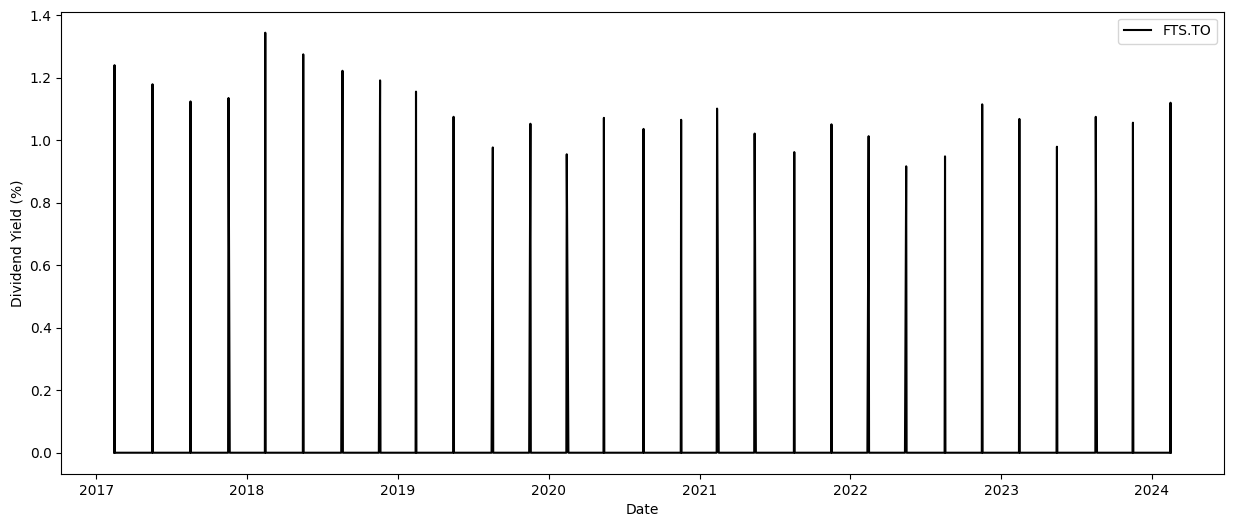

In [44]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(share_all_price.index, share_all_price['dividend_yield'], color='k', label=share_name)

ax1.set_xlabel('Date')
ax1.set_ylabel('Dividend Yield (%)', color='k')

plt.legend()
plt.show()

In [45]:
share_price_currency_rate_correlation = pd.merge_asof(left=usd_nat_curr, right=share_all_price, on='date')
share_price_currency_rate_correlation.index = share_price_currency_rate_correlation['date']
share_price_currency_rate_correlation = share_price_currency_rate_correlation[['currency_rate', 'share_price']]

share_price_currency_rate_correlation.corr()['share_price']

currency_rate   -0.070266
share_price      1.000000
Name: share_price, dtype: float64

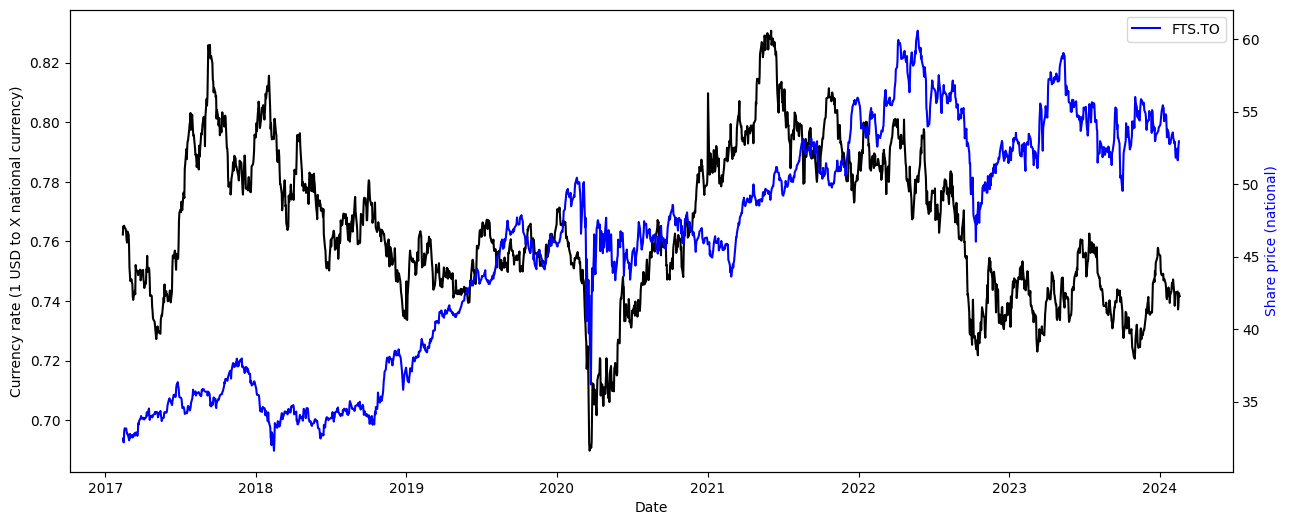

In [46]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax2 = ax1.twinx()
ax1.plot(usd_nat_curr.index, usd_nat_curr['Close'], color='k', label='USD / national currency')
ax2.plot(share_all_price.index, share_all_price['Close'], color='b', label=share_name)

ax1.set_xlabel('Date')
ax1.set_ylabel('Currency rate (1 USD to X national currency)', color='k')
ax2.set_ylabel('Share price (national)', color='b')

plt.legend()
plt.show()

# Share price and value ratios

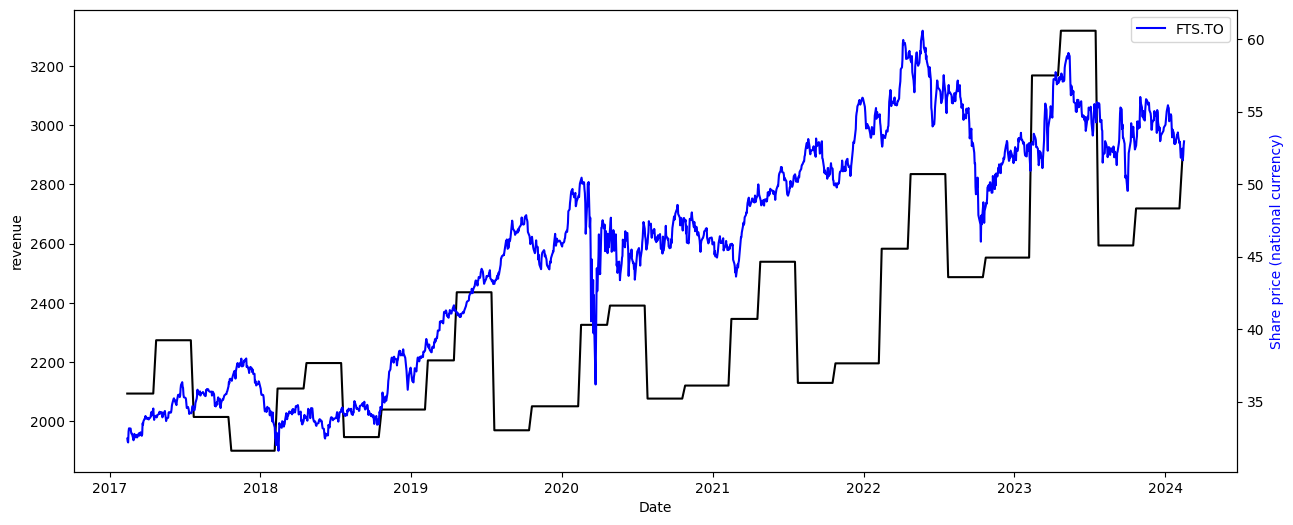

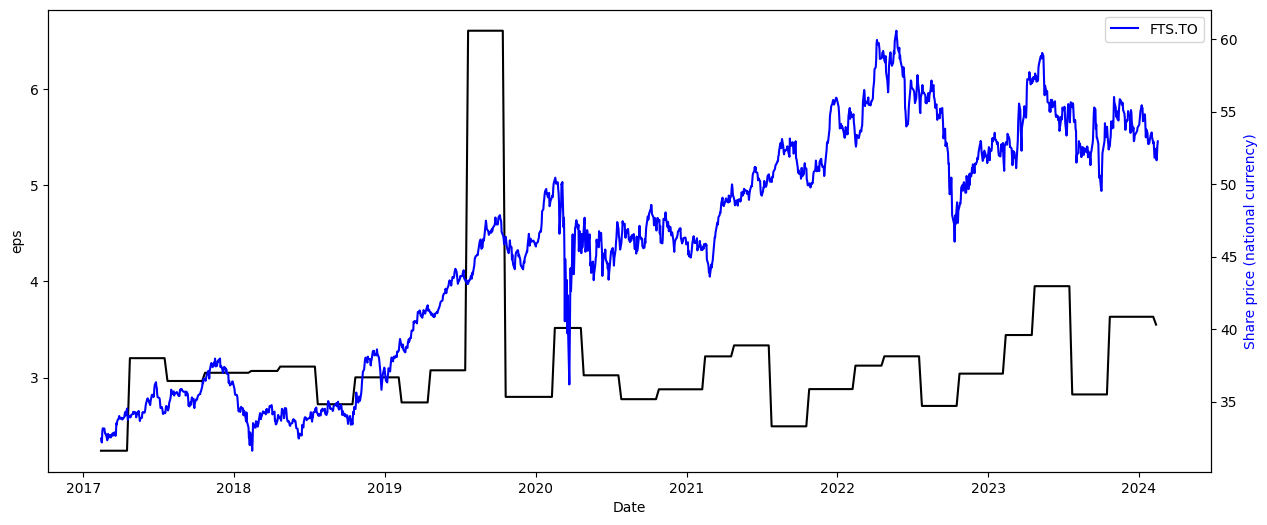

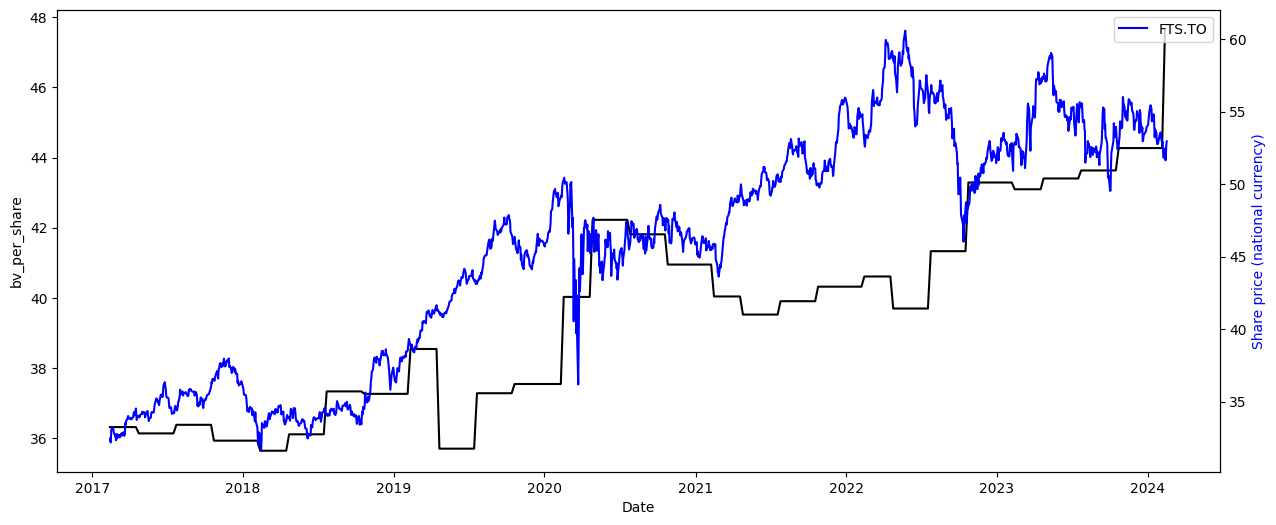

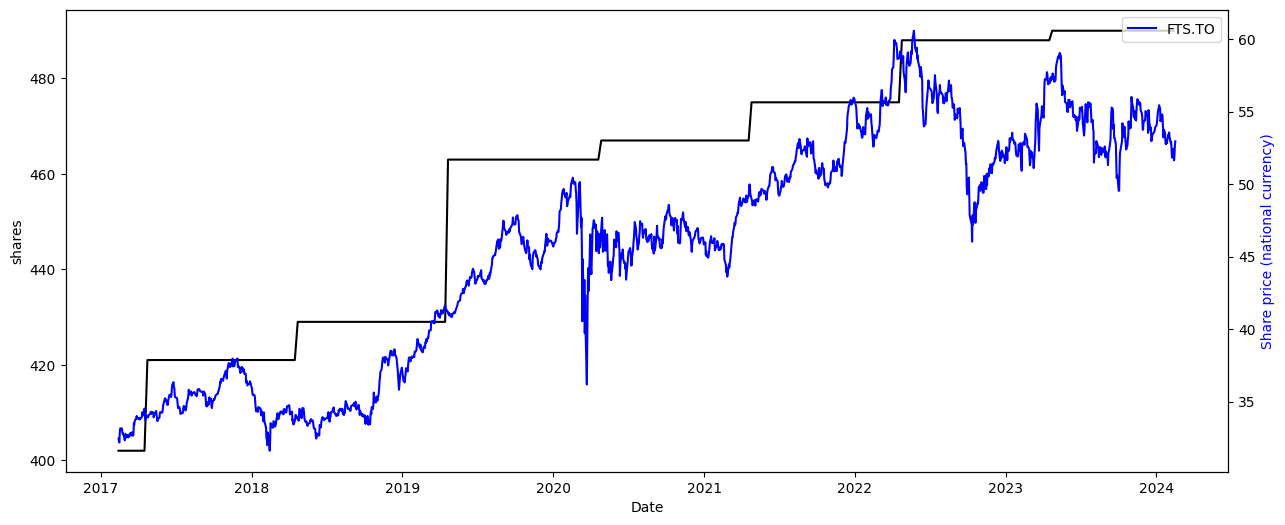

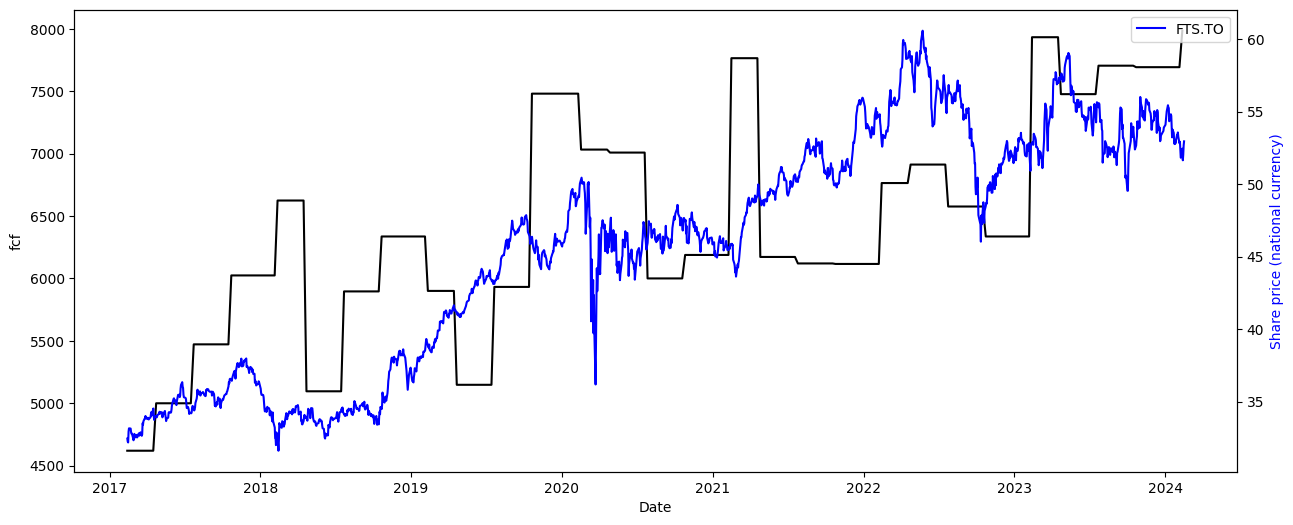

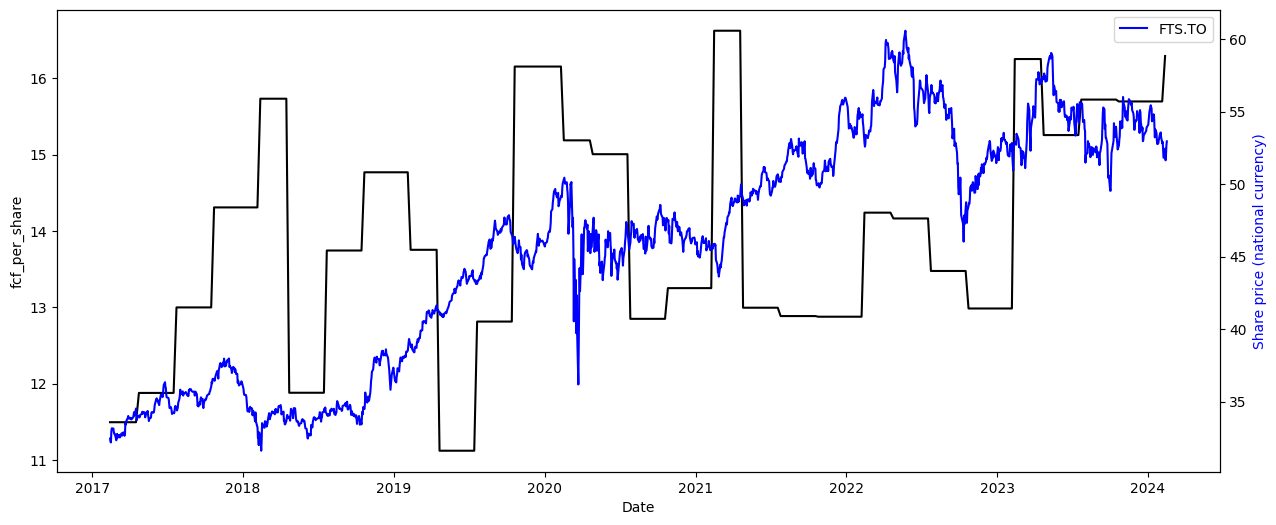

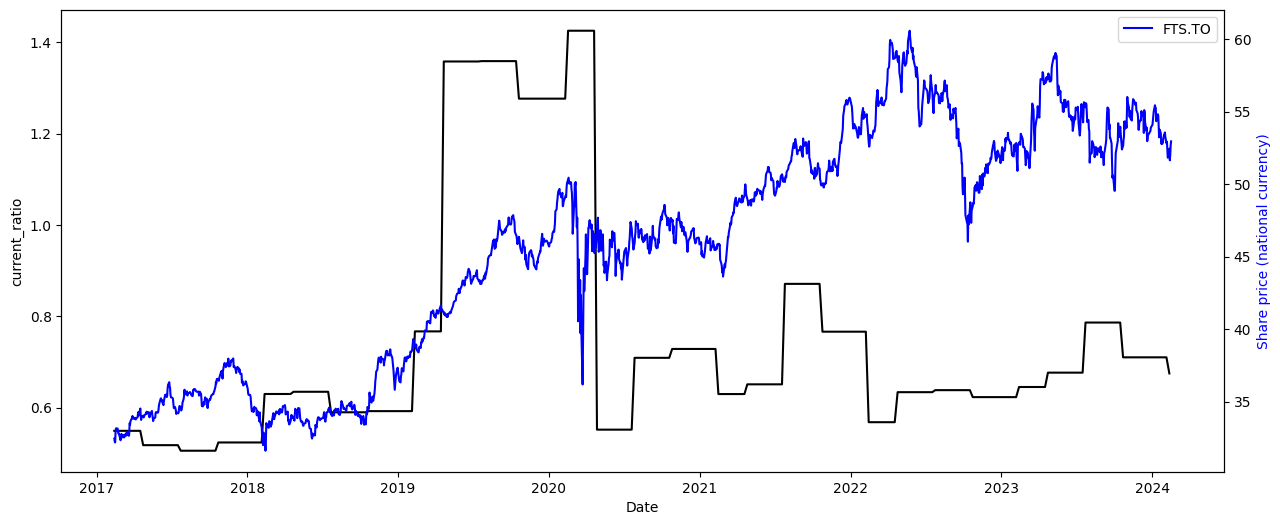

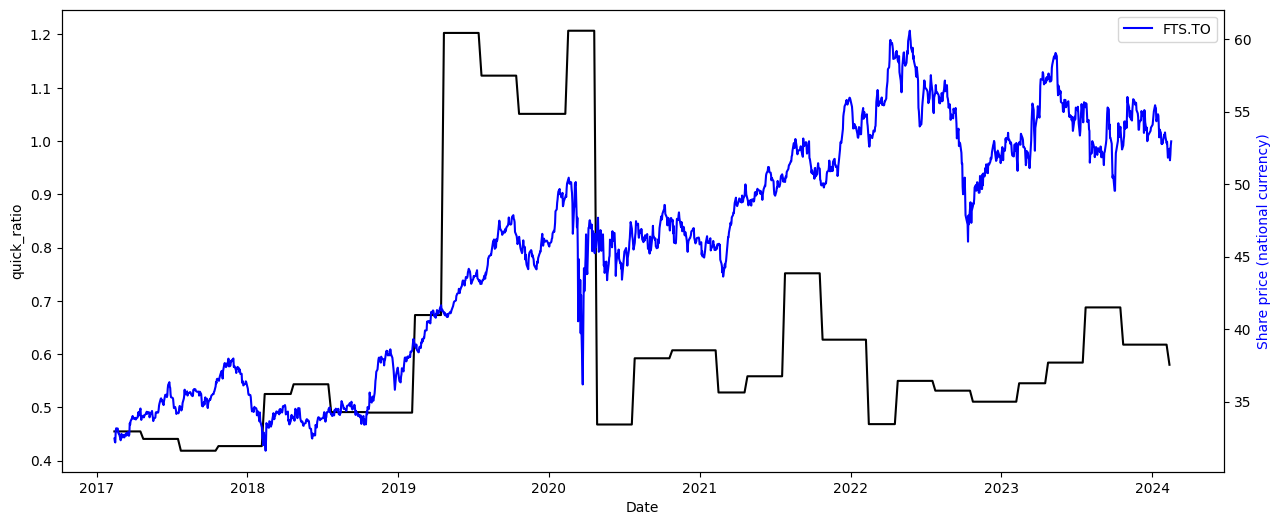

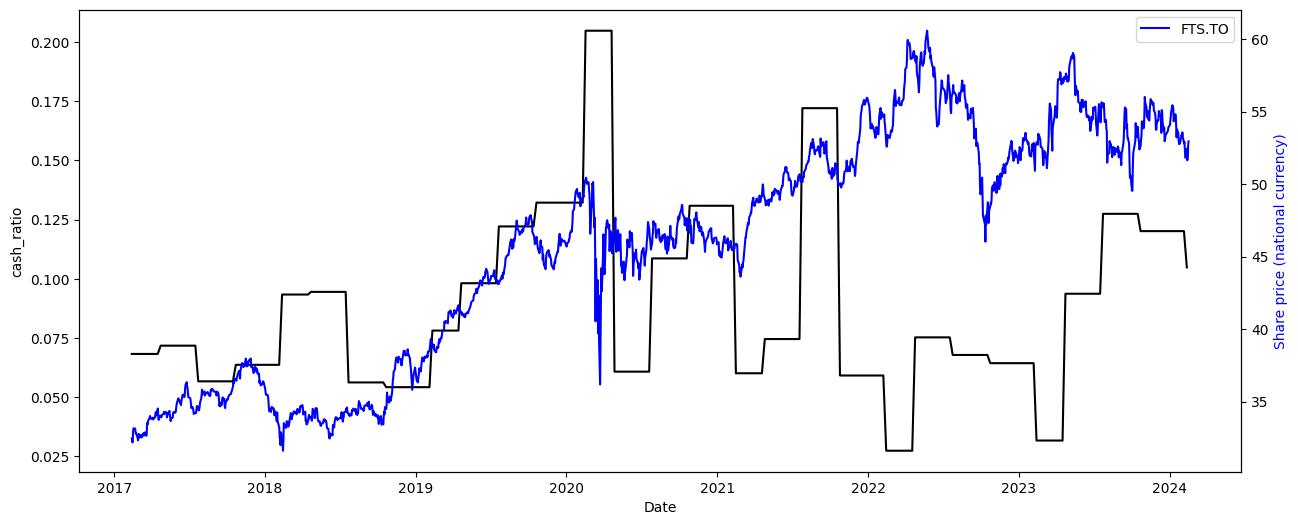

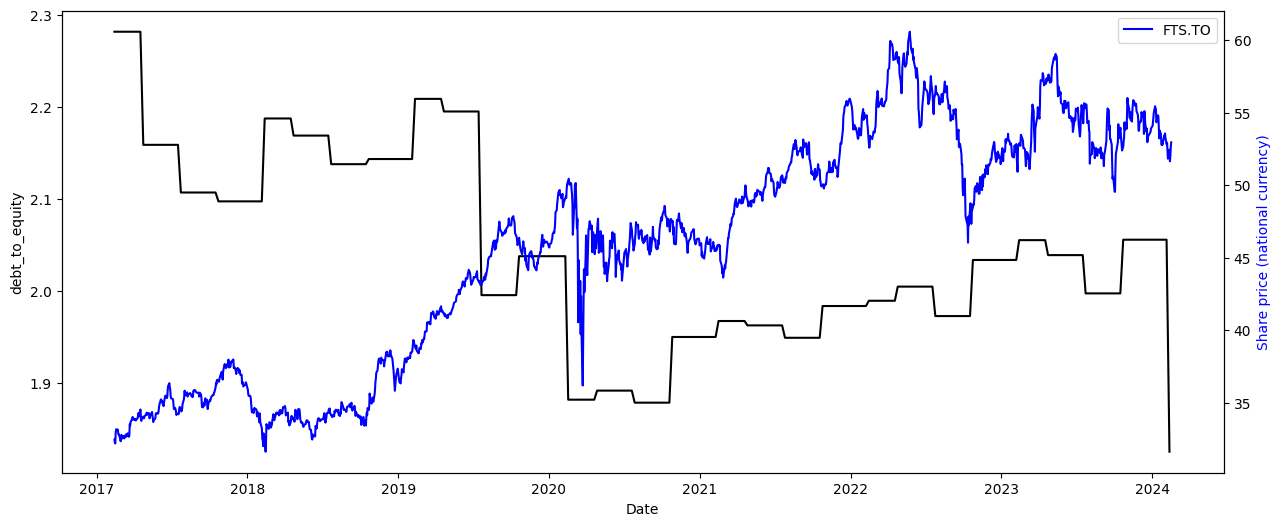

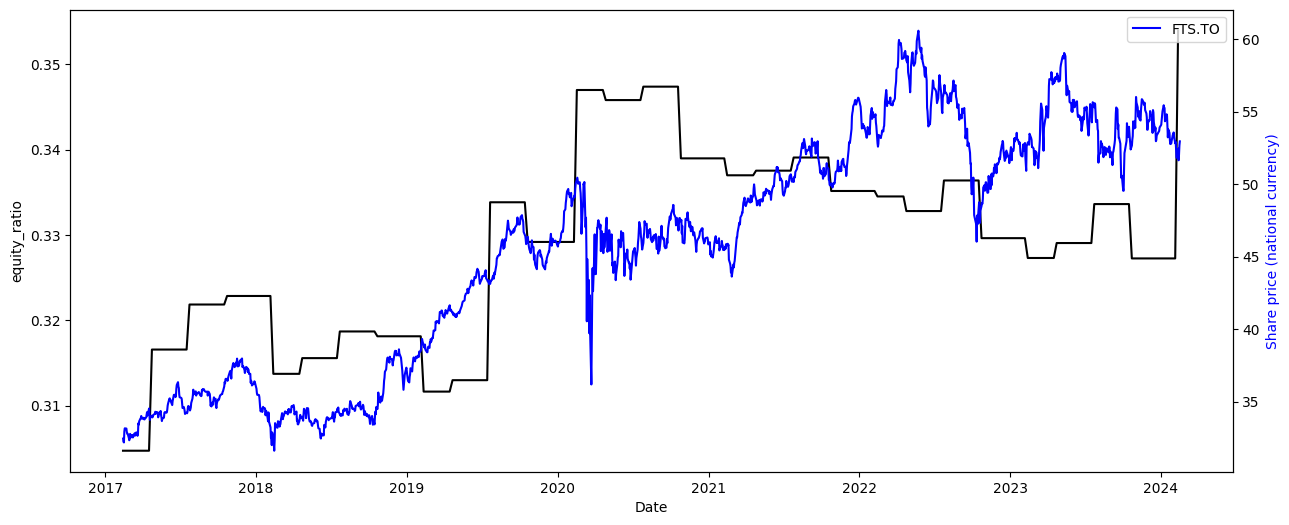

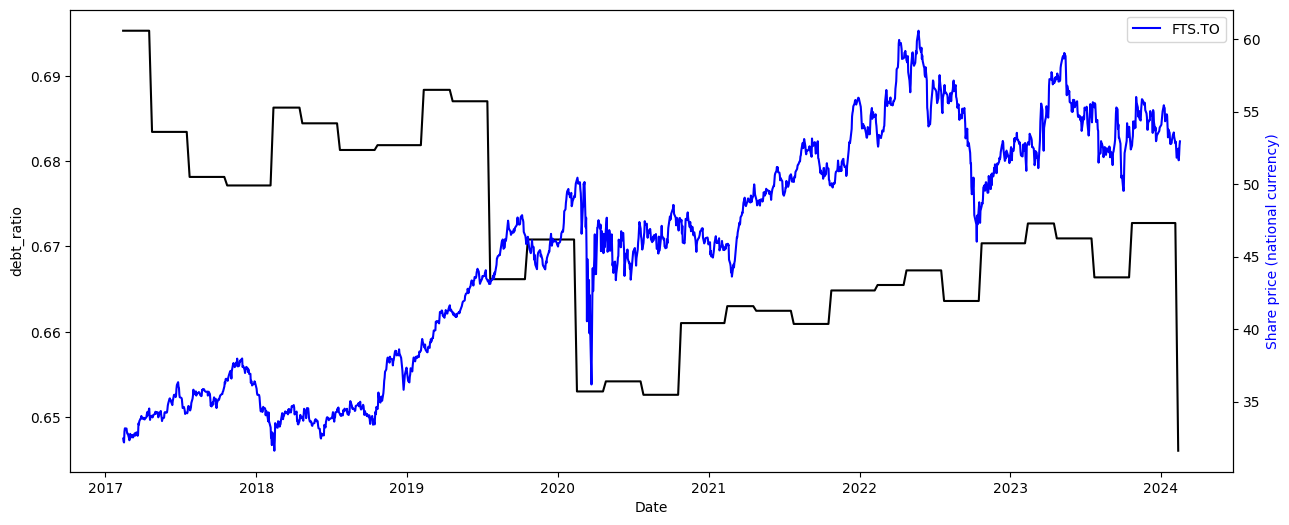

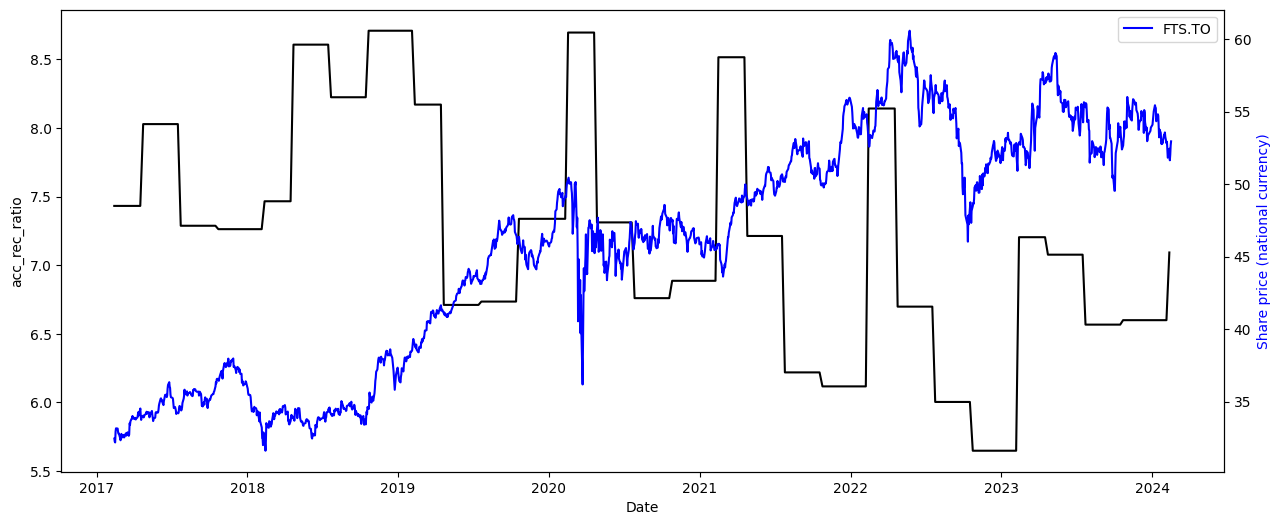

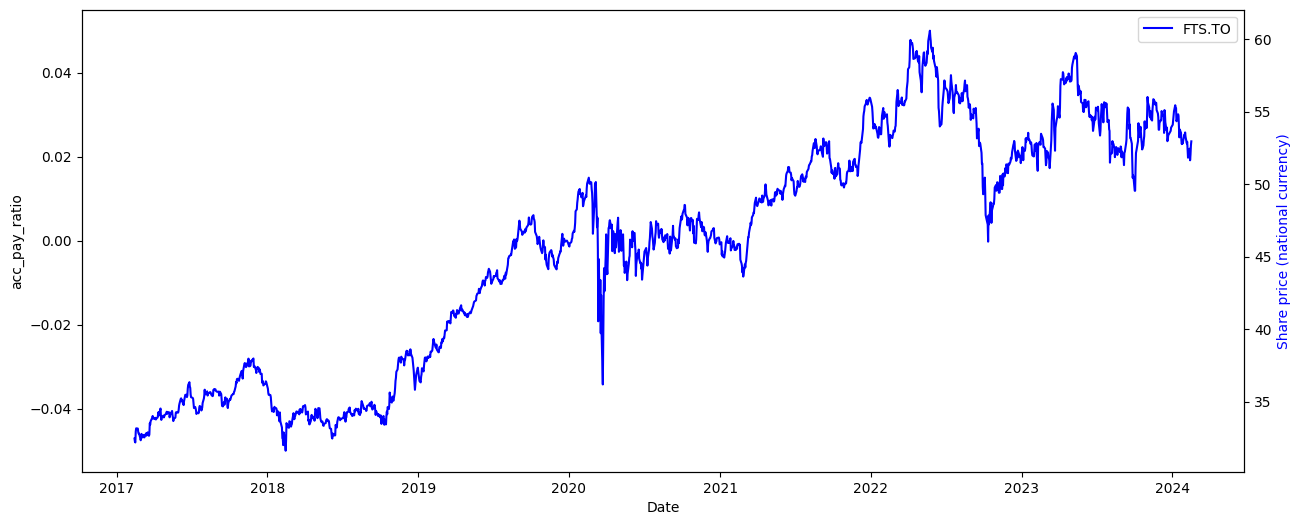

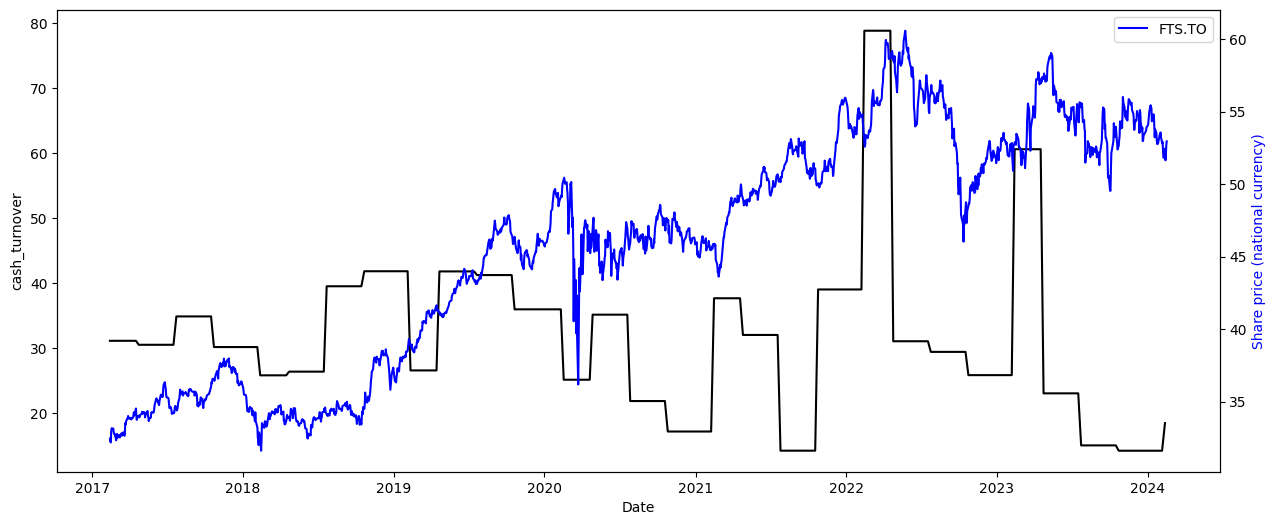

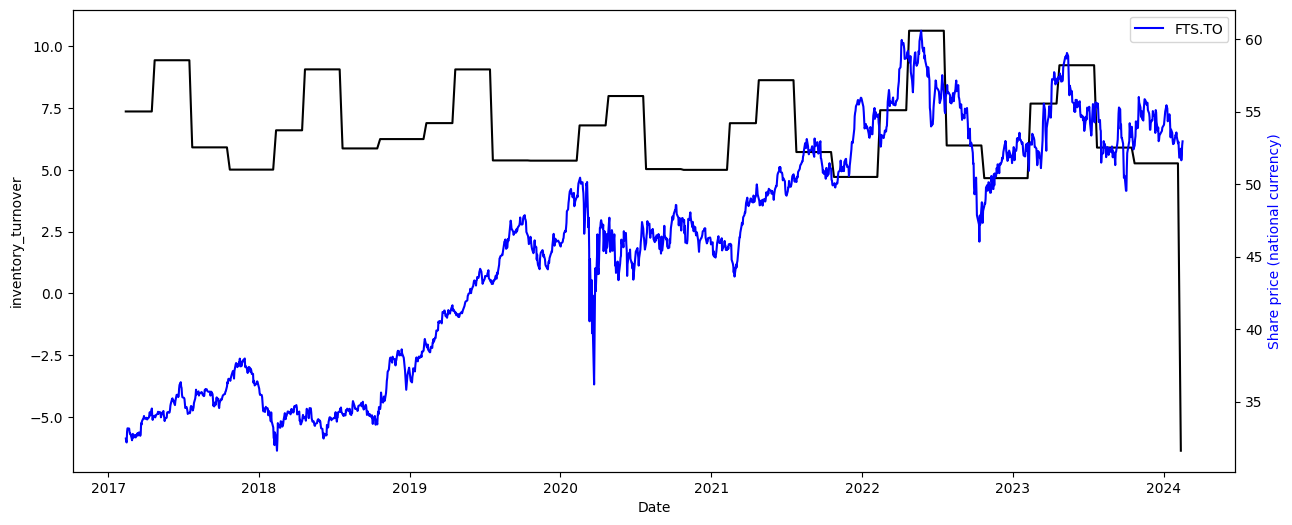

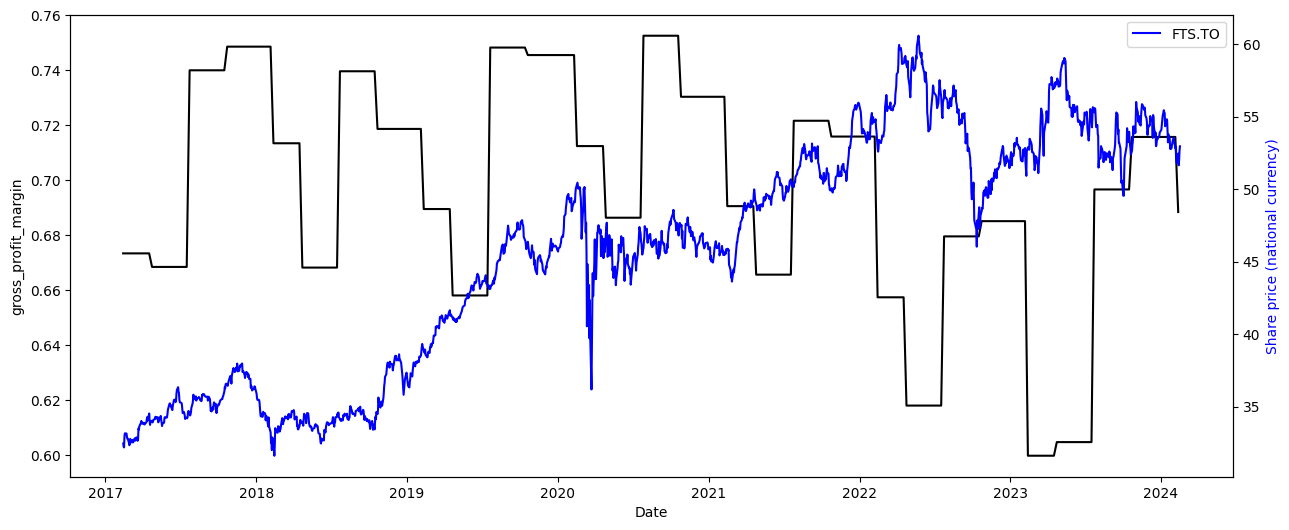

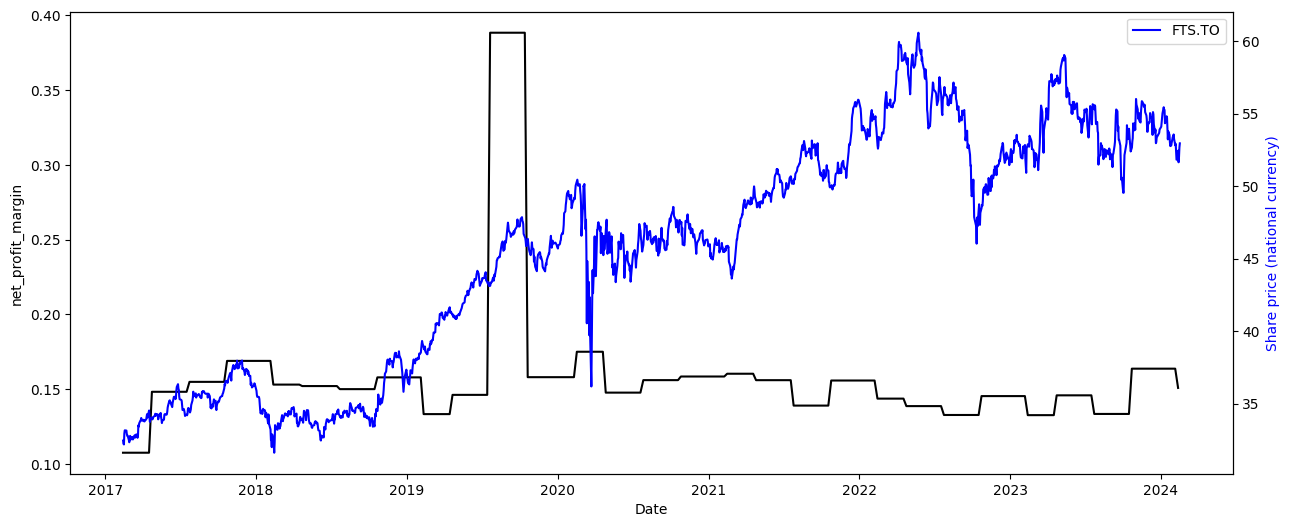

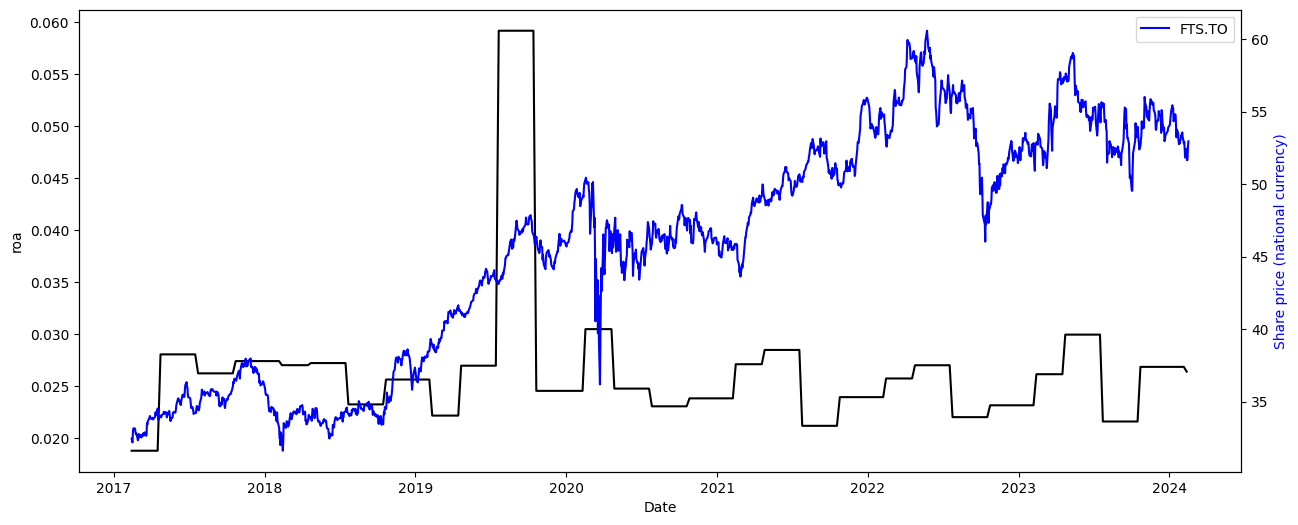

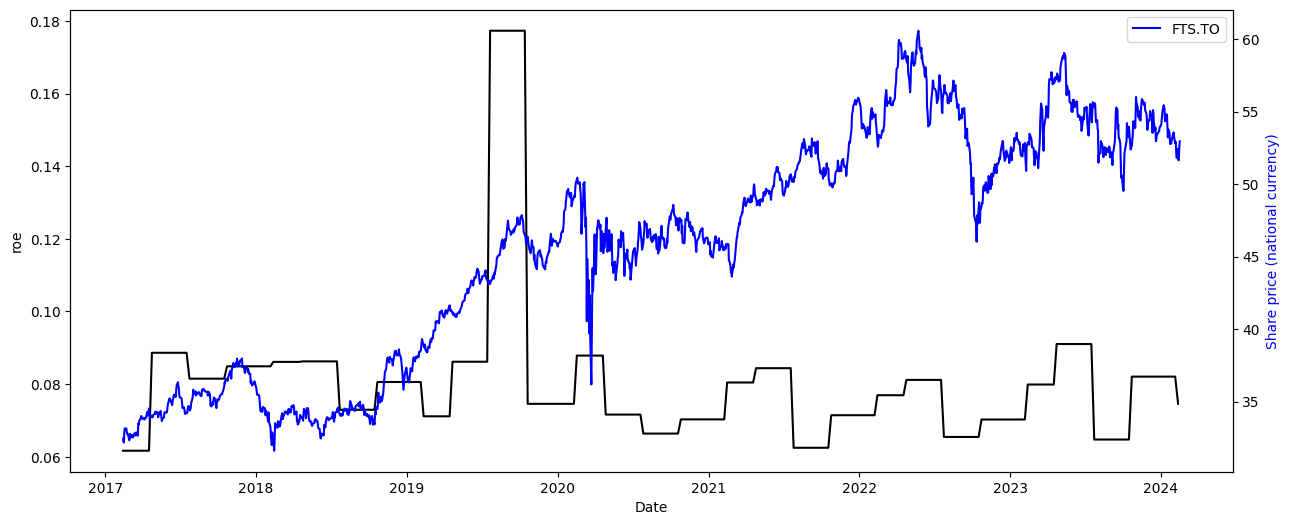

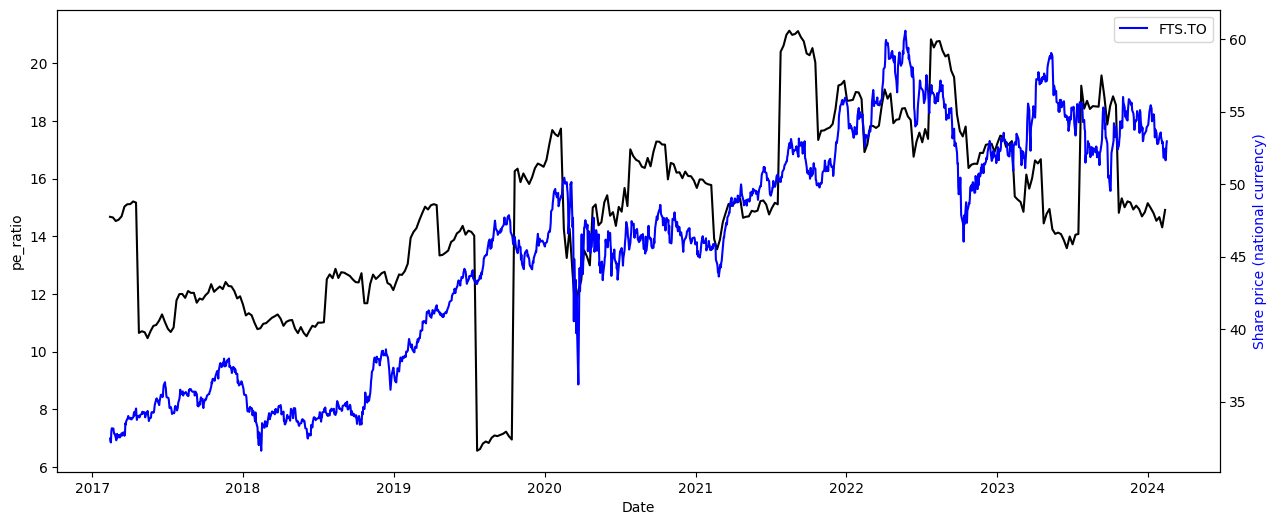

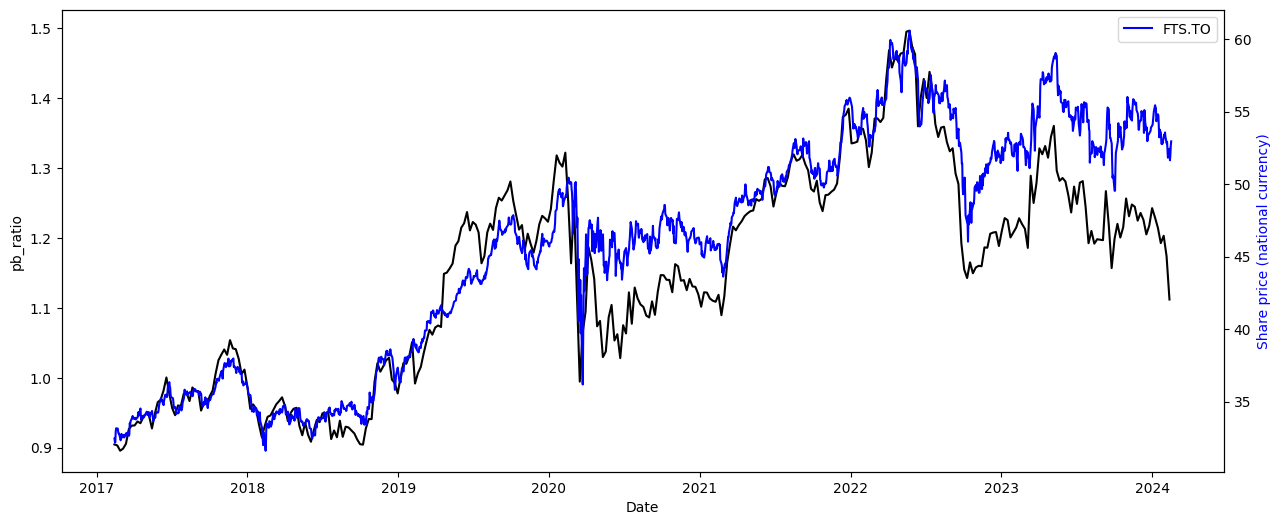

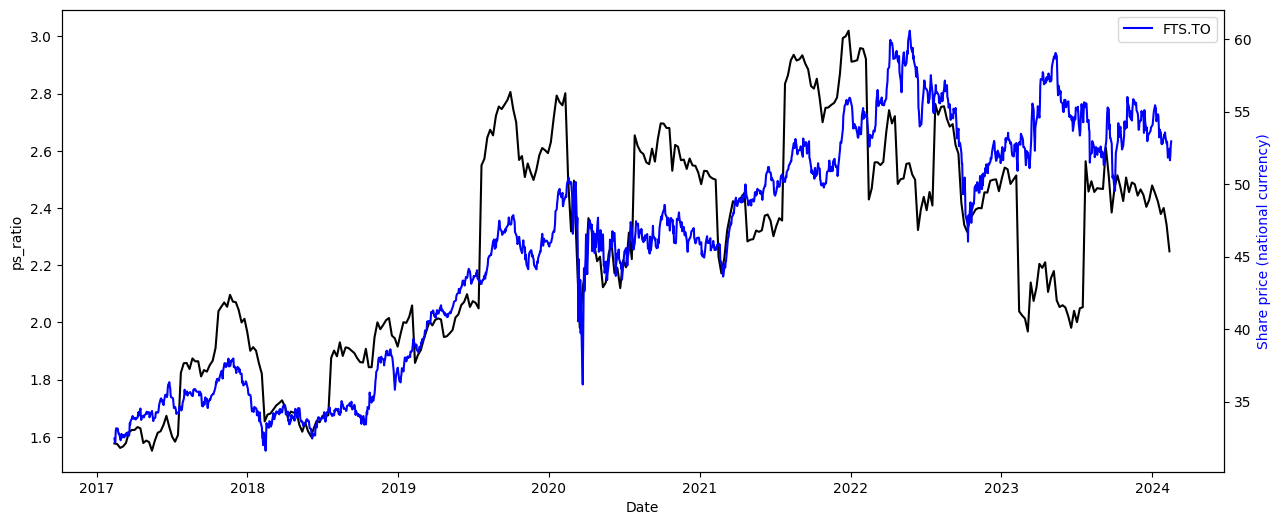

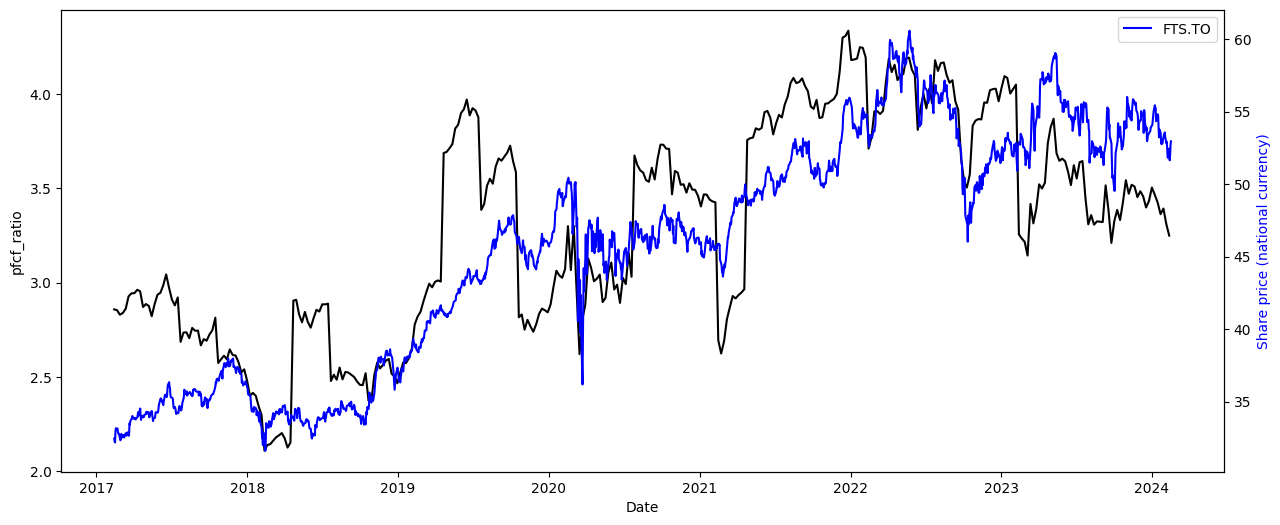

In [47]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(share_all_price.index, share_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

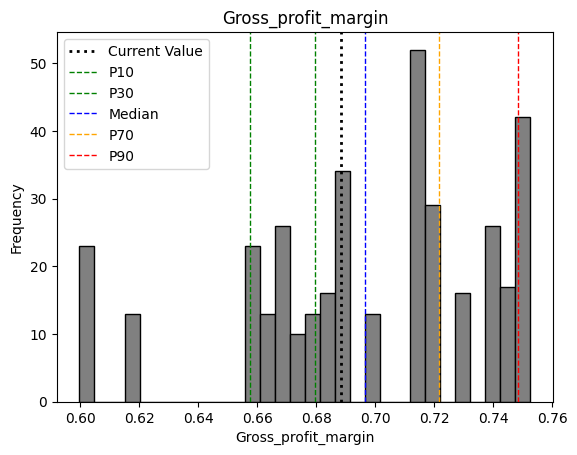

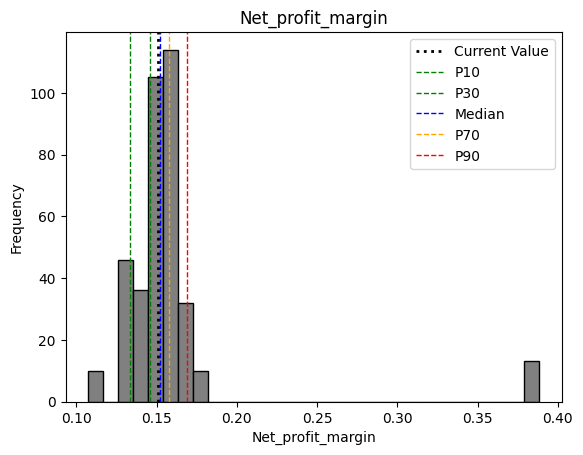

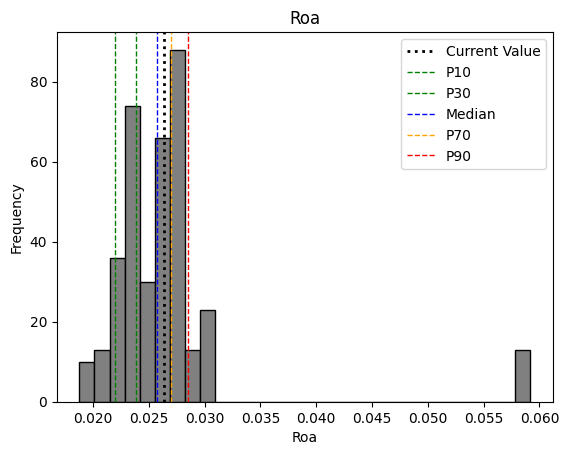

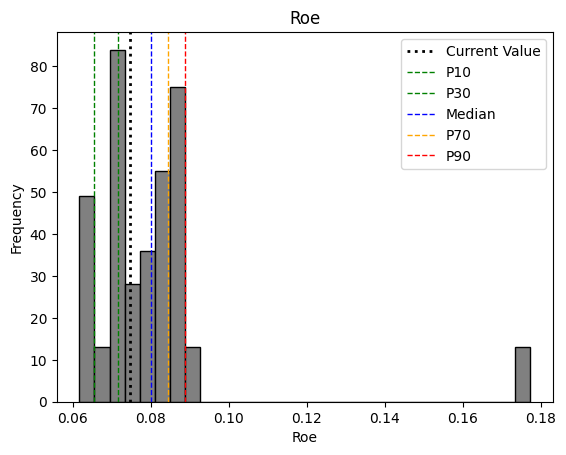

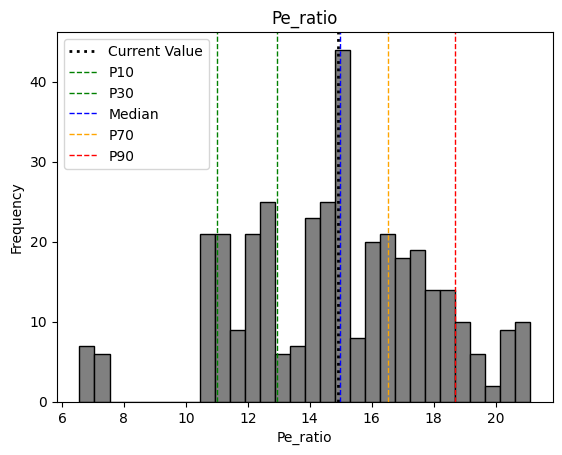

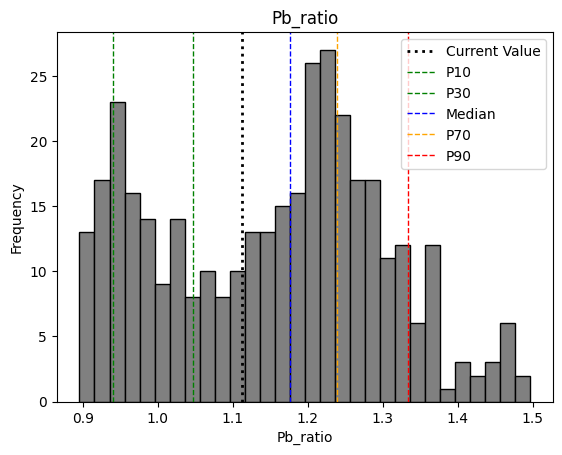

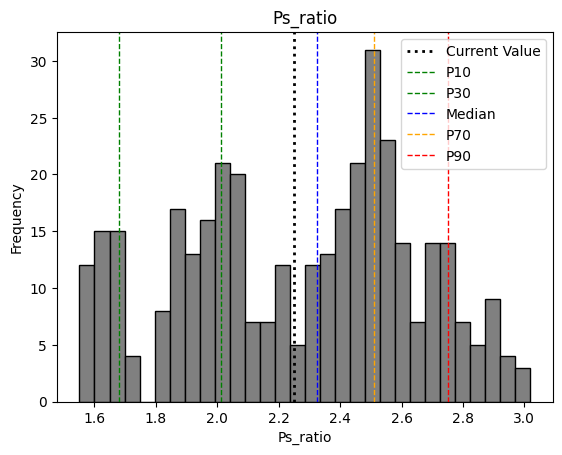

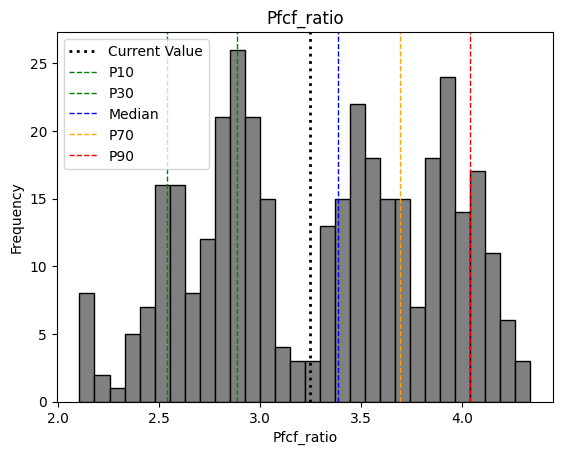

In [48]:
for column in merged_nat_curr.columns[-8:]:
    try:
        plt.hist(merged_nat_curr[column].values, bins=30, edgecolor='black', color='gray')
        plt.axvline(merged_nat_curr[column].iloc[-1], color='k', linestyle='dotted', linewidth=2, label='Current Value')
        plt.axvline(merged_nat_curr[column].quantile(0.1), color='green', linestyle='dashed', linewidth=1, label='P10')
        plt.axvline(merged_nat_curr[column].quantile(0.3), color='green', linestyle='dashed', linewidth=1, label='P30')
        plt.axvline(merged_nat_curr[column].quantile(0.5), color='blue', linestyle='dashed', linewidth=1, label='Median')
        plt.axvline(merged_nat_curr[column].quantile(0.7), color='orange', linestyle='dashed', linewidth=1, label='P70')
        plt.axvline(merged_nat_curr[column].quantile(0.9), color='red', linestyle='dashed', linewidth=1, label='P90')
        
        plt.xlabel(column.capitalize())
        plt.ylabel('Frequency')
        plt.title(column.capitalize())
        
        plt.legend()

        plt.show()
    except:
        print(column + " diagram is missing due to error.")

## Calculate correlation between value parameters

In [49]:
corr_matrix = pd.DataFrame(merged_nat_curr, columns=['real_date', 'gross_profit_margin', 'net_profit_margin', 'roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'pfcf_ratio'])
# find independent columns
corr_matrix.corr()

,real_date,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,pfcf_ratio
real_date,1.000000,-0.369460,-0.118147,-0.103875,-0.173785,0.649290,0.774890,0.649803,0.697288
gross_profit_margin,-0.369460,1.000000,0.363966,0.109119,0.094267,-0.178073,-0.345930,0.222421,-0.347251
net_profit_margin,-0.118147,0.363966,1.000000,0.952342,0.934655,-0.562150,0.074694,0.239091,0.025363
roa,-0.103875,0.109119,0.952342,1.000000,0.992525,-0.639809,0.112497,0.093019,0.032160
roe,-0.173785,0.094267,0.934655,0.992525,1.000000,-0.697806,0.046318,0.001736,-0.027033
pe_ratio,0.649290,-0.178073,-0.562150,-0.639809,-0.697806,1.000000,0.627441,0.639199,0.624603
pb_ratio,0.774890,-0.345930,0.074694,0.112497,0.046318,0.627441,1.000000,0.793065,0.833192
ps_ratio,0.649803,0.222421,0.239091,0.093019,0.001736,0.639199,0.793065,1.000000,0.714262
pfcf_ratio,0.697288,-0.347251,0.025363,0.032160,-0.027033,0.624603,0.833192,0.714262,1.000000


In [50]:
tolerance = 0.1

In [51]:
npm = merged_nat_curr[(merged_nat_curr['net_profit_margin']<= merged_nat_curr['net_profit_margin'].iloc[-1] * (1+tolerance)) & (merged_nat_curr['net_profit_margin']>= merged_nat_curr['net_profit_margin'].iloc[-1] * (1- tolerance))]['date'].values
roe = merged_nat_curr[(merged_nat_curr['roe']<= merged_nat_curr['roe'].iloc[-1] * (1+tolerance)) & (merged_nat_curr['roe']>= merged_nat_curr['roe'].iloc[-1] * (1- tolerance))]['date'].values
per = merged_nat_curr[(merged_nat_curr['pe_ratio']<= merged_nat_curr['pe_ratio'].iloc[-1] * (1+tolerance)) & (merged_nat_curr['pe_ratio']>= merged_nat_curr['pe_ratio'].iloc[-1] * (1- tolerance))]['date'].values
pbr = merged_nat_curr[(merged_nat_curr['pb_ratio']<= merged_nat_curr['pb_ratio'].iloc[-1] * (1+tolerance)) & (merged_nat_curr['pb_ratio']>= merged_nat_curr['pb_ratio'].iloc[-1] * (1- tolerance))]['date'].values
psr = merged_nat_curr[(merged_nat_curr['ps_ratio']<= merged_nat_curr['ps_ratio'].iloc[-1] * (1+tolerance)) & (merged_nat_curr['ps_ratio']>= merged_nat_curr['ps_ratio'].iloc[-1] * (1- tolerance))]['date'].values
pfcfr = merged_nat_curr[(merged_nat_curr['pfcf_ratio']<= merged_nat_curr['pfcf_ratio'].iloc[-1] * (1+tolerance)) & (merged_nat_curr['pfcf_ratio']>= merged_nat_curr['pfcf_ratio'].iloc[-1] * (1- tolerance))]['date'].values

In [52]:
test3 =  utils.list_intersect(npm, roe)
test4 =  utils.list_intersect(test3, per)
test5 =  utils.list_intersect(test4, pbr)
test6 =  utils.list_intersect(test5, psr)
test7 =  utils.list_intersect(test6, pfcfr)
print(len(test7), 'timestemos have been found!')

24 timestemos have been found!


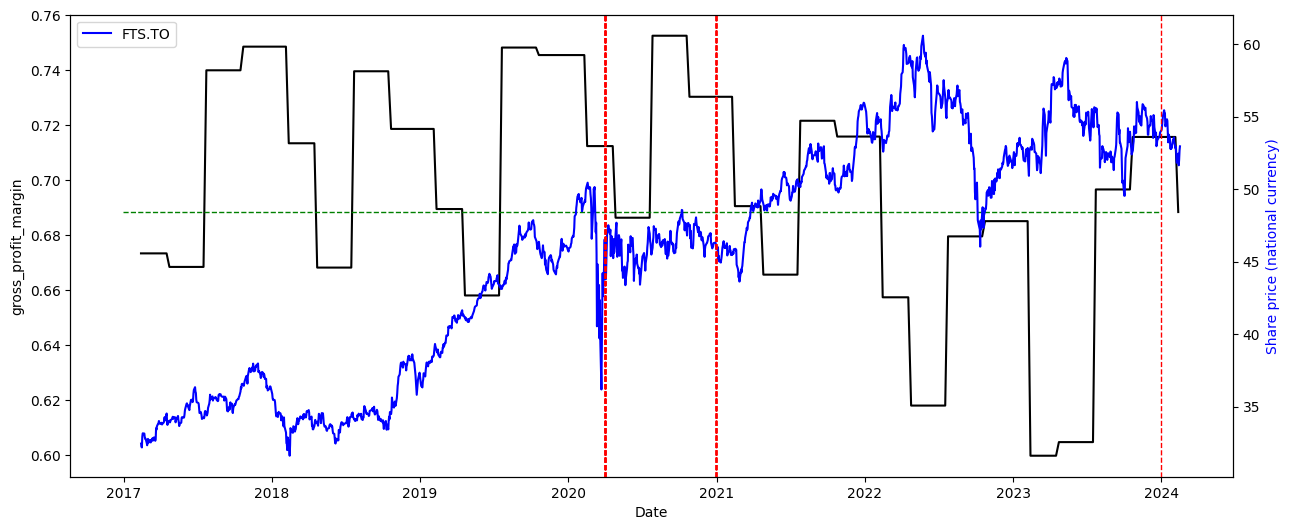

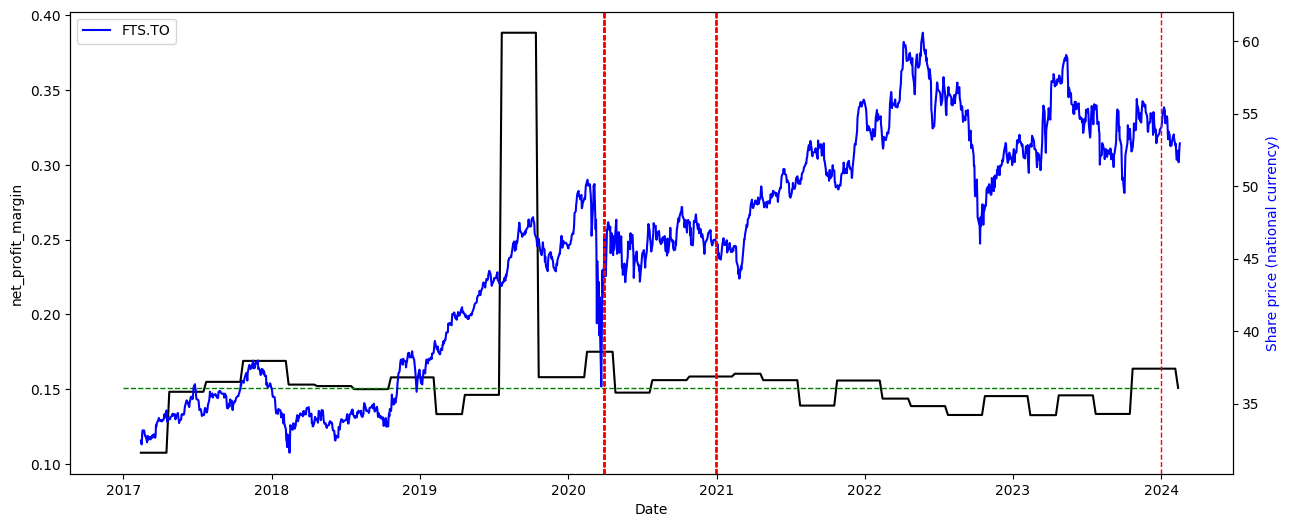

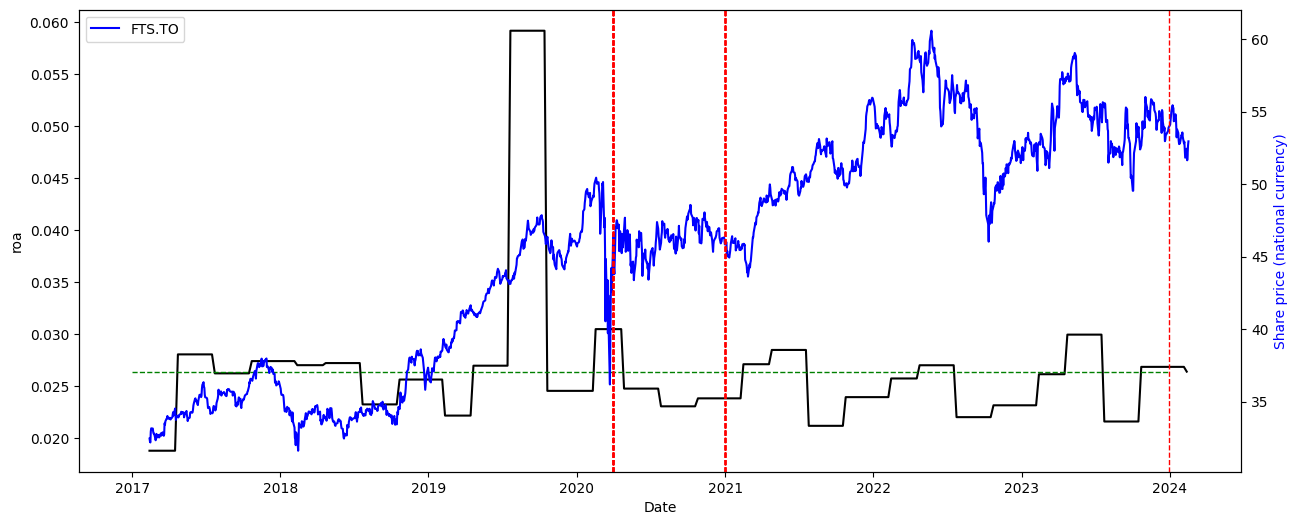

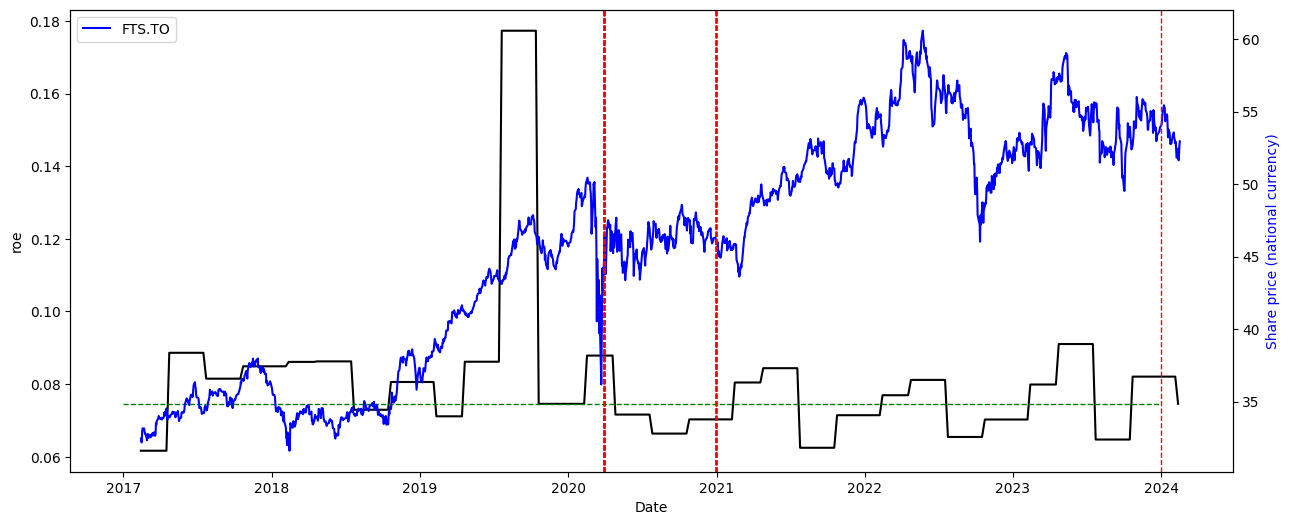

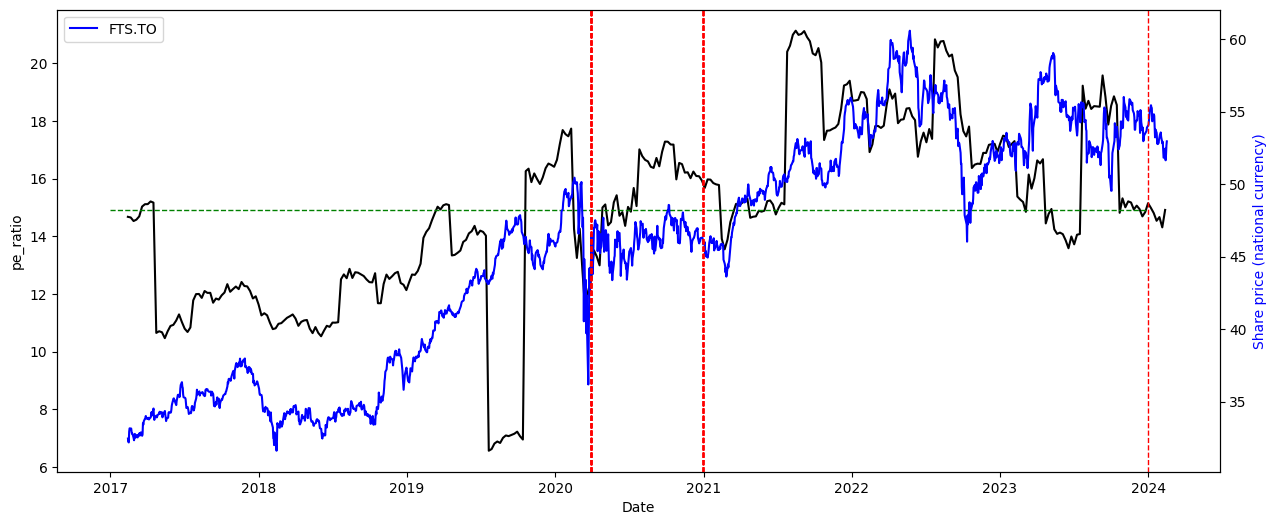

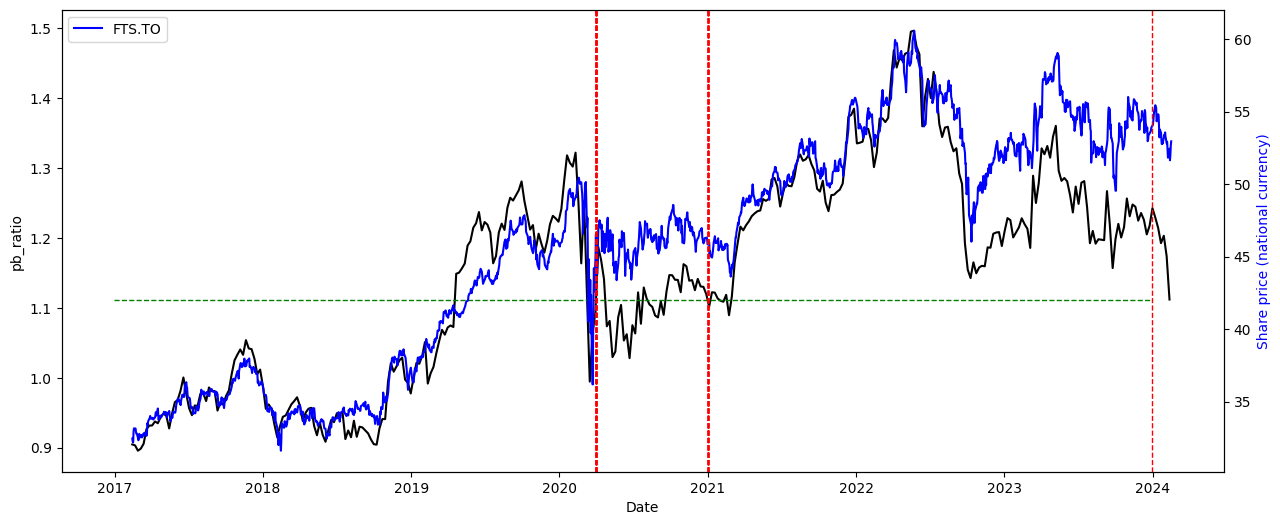

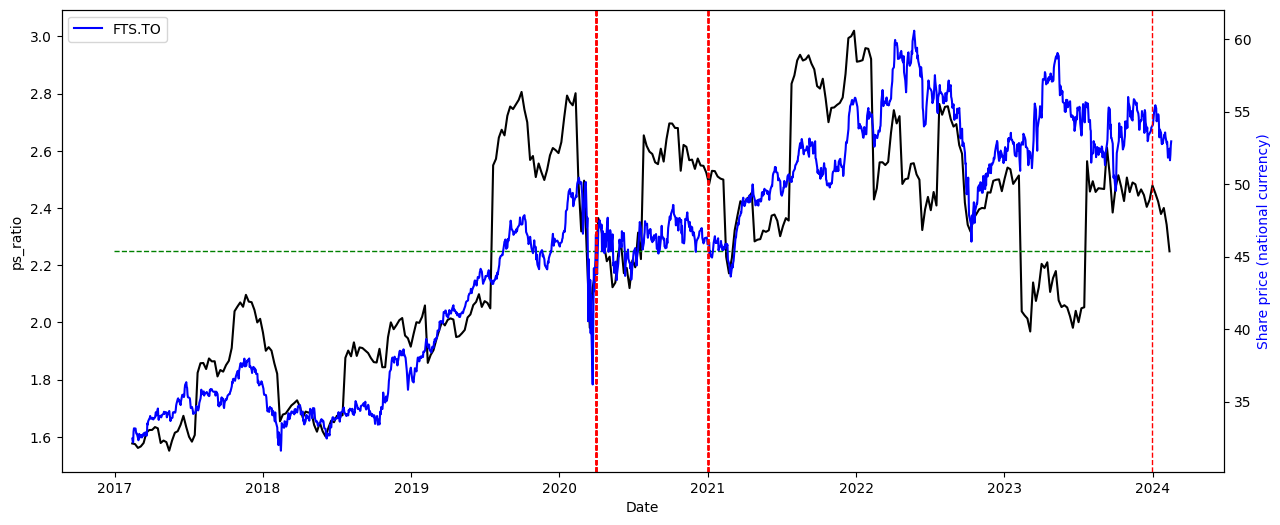

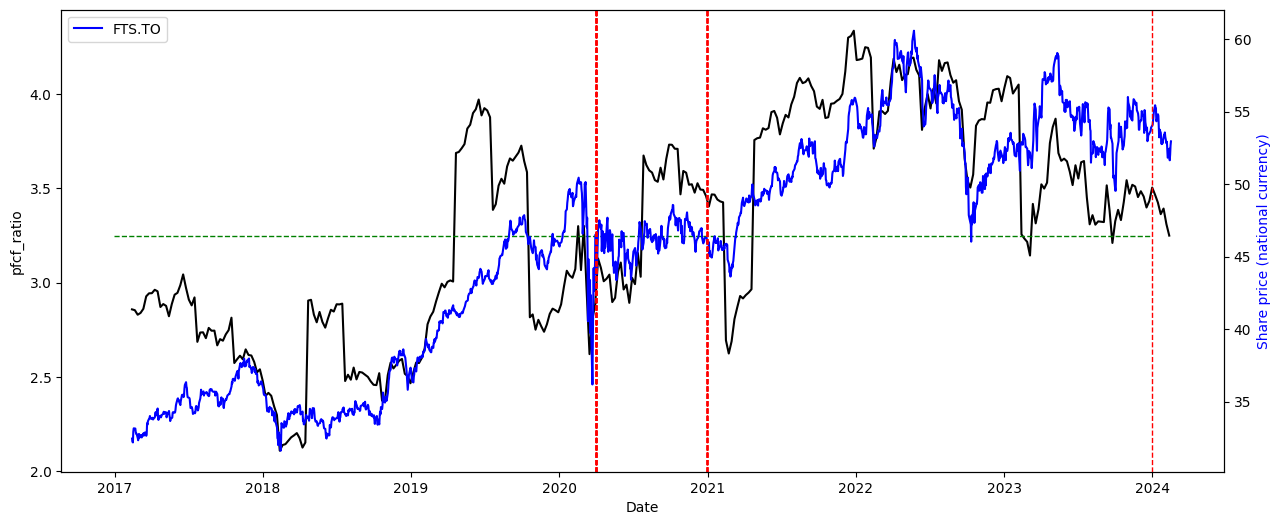

In [53]:
for column in merged_nat_curr.columns[-8:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(share_all_price.index, share_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    for timestamp in test7:
        plt.axvline(timestamp, color='red', linestyle='dashed', linewidth=1)

    ax1.hlines(
        y=merged_nat_curr[column].iloc[-1],
        xmin=merged_nat_curr.date.min(),
        xmax=merged_nat_curr.date.max(),
        linewidth=1, linestyles='dashed',
        color='green',
        )

    plt.legend()
    plt.show()